In [4]:
cat ./data/student.txt

# Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2 sex - student's sex (binary: "F" - female or "M" - male)
3 age - student's age (numeric: from 15 to 22)
4 address - student's home address type (binary: "U" - urban or "R" - rural)
5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or 

# Summary data analysys and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from sklearn import cross_validation
from pandas.tools.plotting import scatter_matrix
from IPython.display import display

import pylab


In [2]:
%matplotlib inline
plt.style.use('ggplot')
pd.options.display.mpl_style = 'default'
student_mat = pd.read_csv("./data/student-mat.csv", sep = ";")
student_por = pd.read_csv("./data/student-por.csv", sep = ";")

Kolmogorov-Smirnow test shows that alcohol consumption rates for different courses are very likely to be drawn from the same distribution, so I suppose that we can merge two courses without significantly decreasing alcohol consumption prediction accuracy for each course separately.

In [3]:
display(stats.ks_2samp(student_mat['Walc'], student_por['Walc']))
display(stats.ks_2samp(student_mat['Dalc'], student_por['Dalc']))

Ks_2sampResult(statistic=0.014241969144350608, pvalue=0.99999999971045828)

Ks_2sampResult(statistic=0.0072516627333190087, pvalue=1.0000000000000002)

In [4]:
display(student_por.shape)
display(student_mat.shape)

(649, 33)

(395, 33)

Let's do some preprocessing. Dalc and Walc together can represend alcohol consumption over the whole week. Reducing those features can improve our model since (highly likely) they are correlated 

In [5]:
# TODO: Dalc + Walc processing
def process_alc(data):
    result = data
    result['alc'] = data.apply(lambda row: ((row['Dalc'] * 5.0) + (row['Walc'] * 2.0)) / 7, axis = 1)
    result.drop(['Dalc', 'Walc'], inplace = True, axis = 1)
    return result

process_alc(student_mat);
process_alc(student_por);

In [345]:
student_mat.head(1)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,health,absences,G1,G2,G3,alc
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,3,6,5,6,6,1


Group students who attended both courses and average their features:

In [6]:
students = pd.concat([student_mat, student_por]).groupby(["school",
                                                          "sex",
                                                          "age",
                                                          "address",
                                                          "famsize",
                                                          "Pstatus",
                                                          "Medu",
                                                          "Fedu",
                                                          "Mjob",
                                                          "Fjob",
                                                          "reason",
                                                          "nursery",
                                                          "internet"]).mean().reset_index()

students['alc'] = students['alc'].apply(np.rint)
students.shape

(662, 25)

Not so much students with high alcohol consumption:

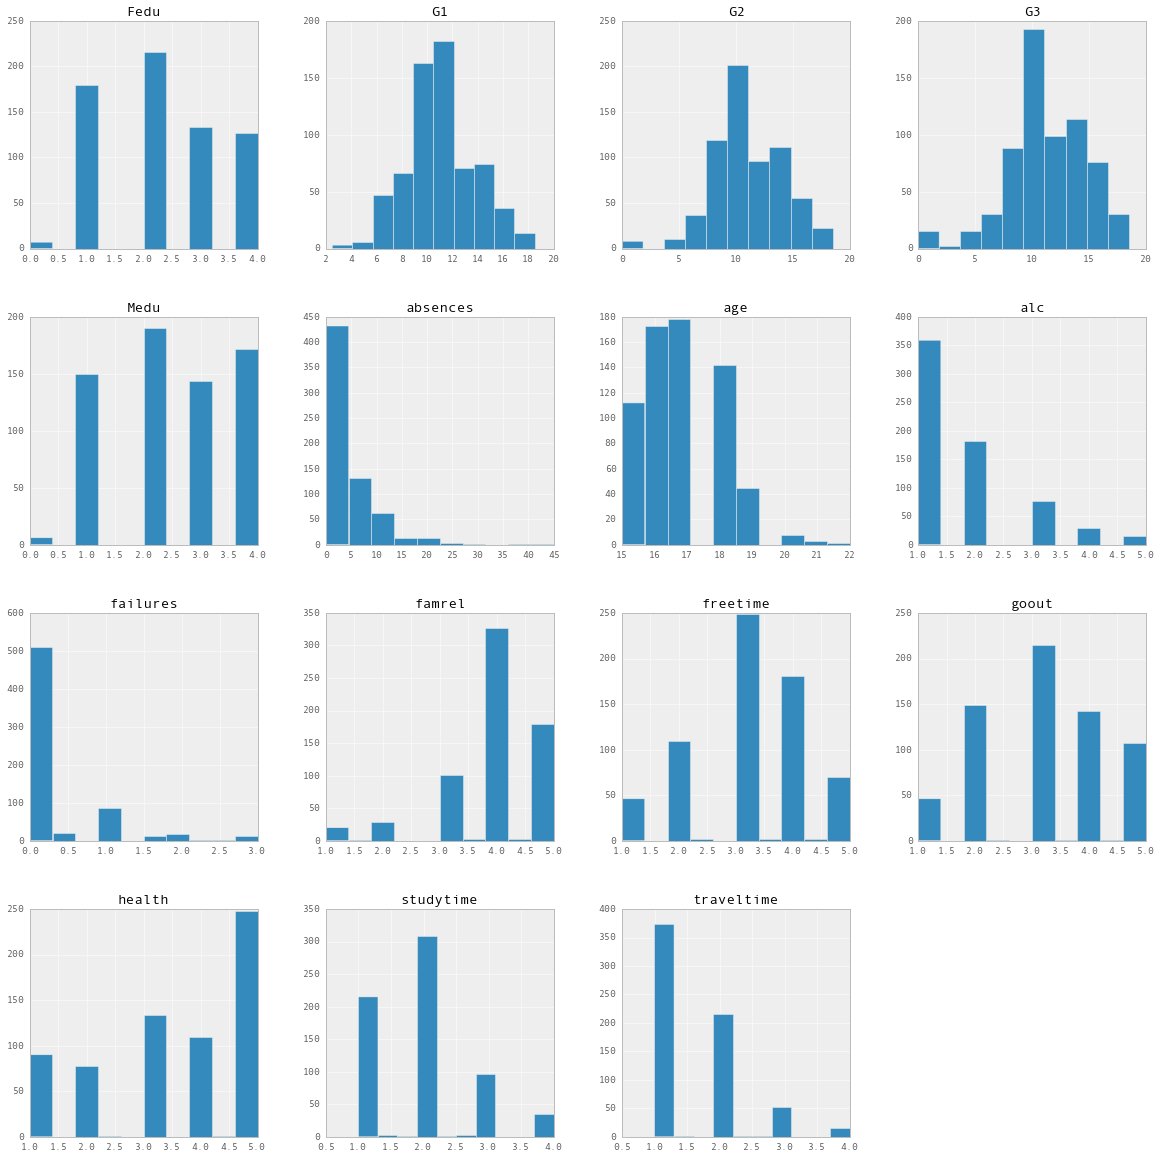

In [7]:
students.hist(figsize=(20, 20));

/home/kernelmode/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


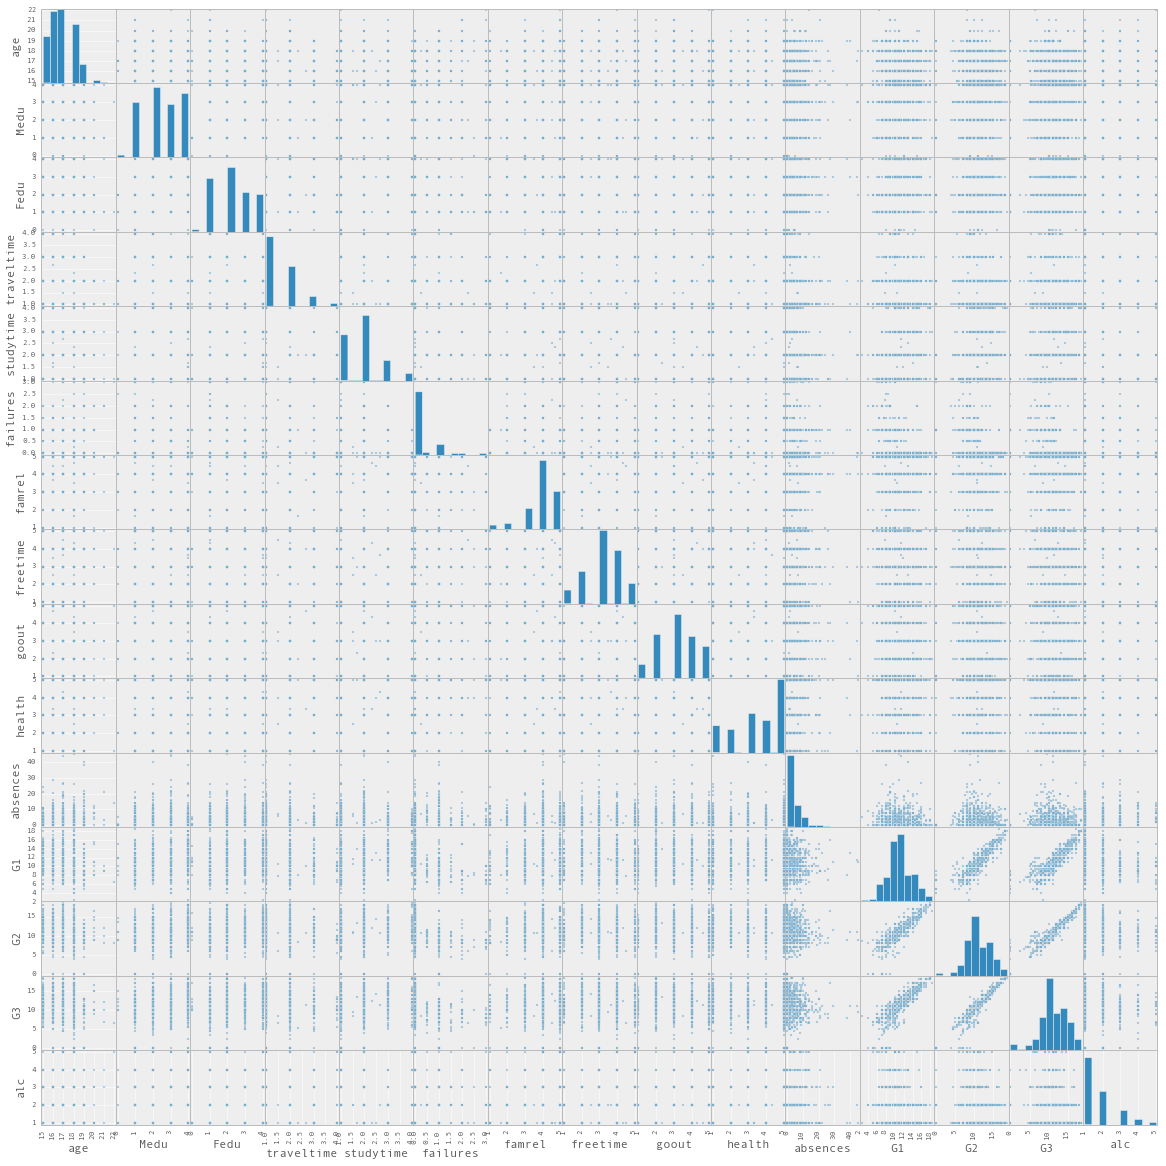

In [8]:
scatter_matrix(students, diagonal = 'hist', figsize=(20, 20));

Feature transformation (for interpretability):

In [9]:
students_transformed = students
students_transformed['male'] = students['sex'] == "M"
students_transformed['rural'] = students['address'] == "R"
students_transformed['big_family'] = students['famsize'] == 'GT3'
students_transformed['parents_together'] = students['Pstatus'] == "T"
students_transformed['studies_less'] = students['studytime'] < 3
students_transformed['more_failures'] = students['failures'] >= 2
students_transformed['bad_relationships'] = students['famrel'] <= 2
students_transformed['more_free_time'] = students['freetime'] > 3
students_transformed['goes_out_more'] = students['goout'] > 4
students_transformed['bad_health'] = students['health'] <= 2
students_transformed['high_absences'] = students['absences'] > (students['absences'].std() * 2)
students_transformed['drinker'] = students['alc'] >= 3
students_transformed['mothers_low_edu'] = students['Medu'] <= 3
students_transformed['fathers_low_edu'] = students['Fedu'] <= 3
students_transformed['more_than_18'] = students['age'] > 18
students_transformed['long_road'] = students['traveltime'] >= 3

sum_grade = students['G1'] + students['G2'] + students['G3']
mean_grade = (sum_grade) / 3 
students_transformed['low_grade'] = mean_grade <= (mean_grade.mean() + mean_grade.std())

students_transformed.drop(['sex', 
                           'address', 
                           'famsize', 
                           'Pstatus', 
                           'studytime', 
                           'failures', 
                           'famrel', 
                           'freetime', 
                           'goout', 
                           'health',
                           'absences',
                           'alc',
                           'G1',
                            'G2',
                            'G3',
                           'Medu',
                           'Fedu',
                           'age',
                           'traveltime'], axis = 1, inplace = True)

Let's see which variables are correlated the most

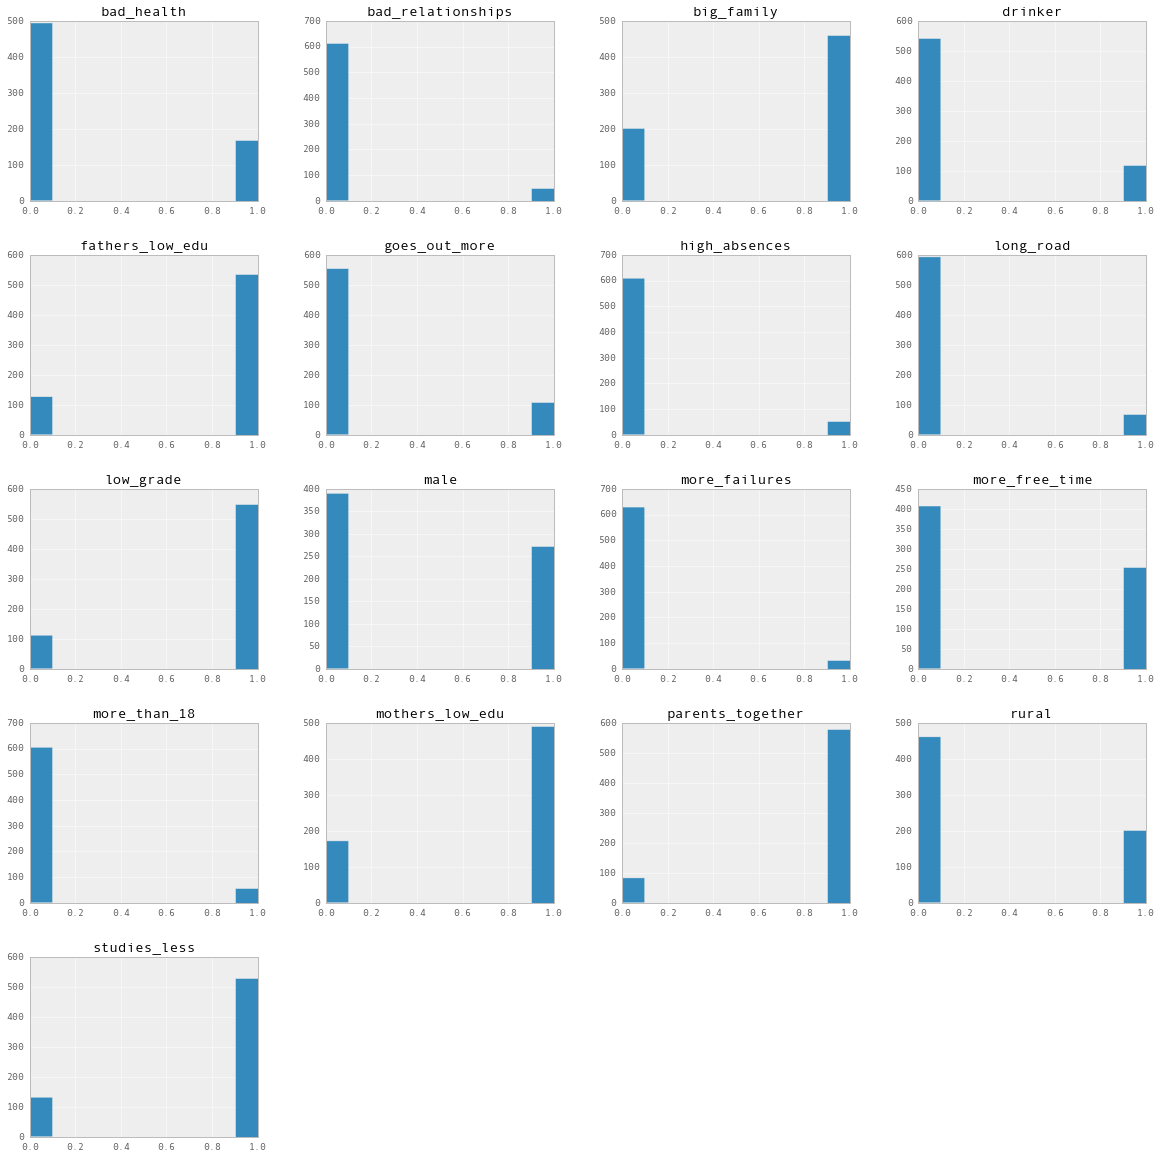

In [10]:
students_transformed.hist(figsize=(20, 20));

We get around 40% accuracy with dummy classifier

In [11]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint

data = students_transformed.drop('drinker', axis = 1)
data = pd.get_dummies(data)
target = students_transformed['drinker']
x_train, x_val, y_train, y_val = cross_validation.train_test_split(data, target, test_size=0.2, random_state=123, stratify = target)

d_clf = DummyClassifier()
cross_val_score(d_clf, data, target).mean()

0.73123123123123124

# Model evaluation
CART gives us more accuracy

In [12]:
from sklearn import tree

param_dist = {
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
    "max_features" : ["sqrt", "log2", None],
    "max_depth" : sp_randint(1, 21),
    "min_samples_split": sp_randint(1, 21),
    "min_samples_leaf": sp_randint(1, 21),
}

clf = tree.DecisionTreeClassifier(class_weight = "balanced")
n_iter_search = 250
random_search = RandomizedSearchCV(clf, param_distributions = param_dist,
                                   n_iter = n_iter_search, random_state = 123)
random_search.fit(x_train, y_train)
print("Best randomized search score - %s" % random_search.best_score_)

clf = random_search.best_estimator_
print("Validation score - %s" % clf.score(x_val, y_val))

Best randomized search score - 0.739130434783
Validation score - 0.684210526316


Decision trees tend to be _very_ variable models, every fit generates pretty different results, so we check more robust ML algorithms 

Random Forests do better

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(class_weight = "balanced")
rf_param_dist ={"n_estimators" : np.arange(10, 100, 10),
                  "max_depth": sp_randint(1, 31),
                  "max_features": sp_randint(1, 11),
                  "min_samples_split": sp_randint(1, 11),
                  "min_samples_leaf": sp_randint(1, 11),
                  "max_features" : ["auto", "sqrt", "log2"],
                  "criterion": ["gini", "entropy"]}

# We could use OOB here, but randomized search will be faster for prototyping. 
# The benefit of using OOB would be the unnecessarity of splitting the data for validation purposes
n_iter_search = 250
random_search = RandomizedSearchCV(rf_clf, param_distributions = rf_param_dist,
                                   n_iter = n_iter_search, random_state = 123)
random_search.fit(x_train, y_train)
rf_clf = random_search.best_estimator_
print("Best randomized search score - %s" % random_search.best_score_)
print("Validation score - %s" % rf_clf.score(x_val, y_val))

Best randomized search score - 0.835538752363
Validation score - 0.781954887218


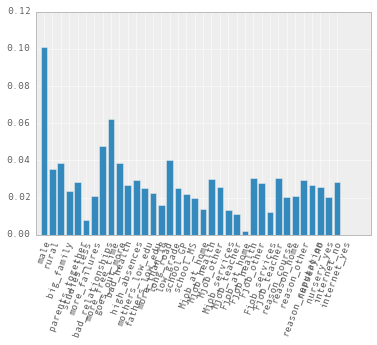

In [15]:
ax = plt.subplot(111)
width = 0.8
names = x_train.columns
bins = list(map(lambda x: x - width / 2, range(1, len(rf_clf.feature_importances_) + 1)))
ax.bar(bins, rf_clf.feature_importances_, width = width)
ax.set_xticks(list(map(lambda x: x, range(1, len(rf_clf.feature_importances_) + 1))))
ax.set_xticklabels(names,rotation = 70)

plt.show()

XGBoost is simillar to random forest in this case

In [17]:
import xgboost as xgb
from scipy.stats import uniform

xgb_param_dist = {"n_estimators" :  np.arange(10, 200, 10),
                  "max_depth": sp_randint(2, 31),
                  "learning_rate" : uniform(loc = 0.01, scale=0.2),
                  "colsample_bytree" : uniform(loc = 0.3, scale = 0.5)}

xgb_clf = xgb.XGBClassifier()
n_iter_search = 250
random_search = RandomizedSearchCV(xgb_clf, param_distributions = xgb_param_dist,
                                   n_iter = n_iter_search, random_state = 123)
random_search.fit(x_train, y_train)
xgb_clf = random_search.best_estimator_
print("Best randomized search score - %s" % random_search.best_score_)
print("Validation score - %s" % xgb_clf.score(x_val, y_val))

Best randomized search score - 0.848771266541
Validation score - 0.834586466165


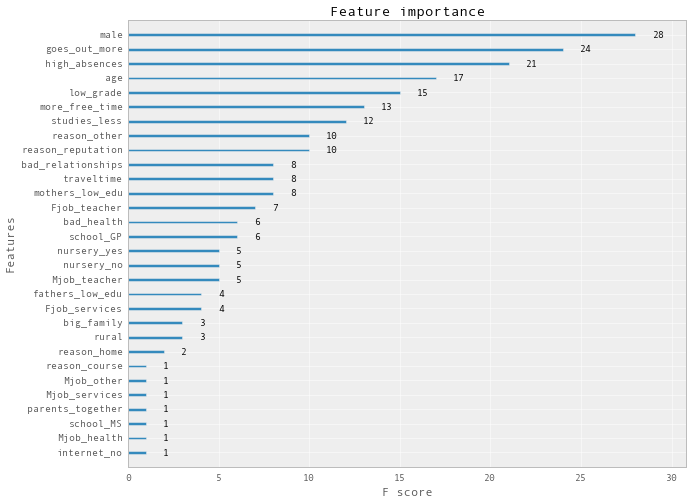

In [647]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
xgb.plot_importance(xgb_clf);

I choose RF as main model (XGBoost and Random Forest give simillar results for this dataset). Now let's do feature selection.

In [20]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rf_clf, prefit = True)
x_train_fs = model.transform(x_train)
x_val_fs = model.transform(x_val)
selected_feature_names = x_train.columns[model.transform(np.arange(len(x_train.columns)))]

n_iter_search = 250
random_search = RandomizedSearchCV(rf_clf, param_distributions = rf_param_dist,
                                   n_iter = n_iter_search, random_state = 123)
random_search.fit(x_train_fs, y_train);

/home/kernelmode/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Now, let's plot feature importances

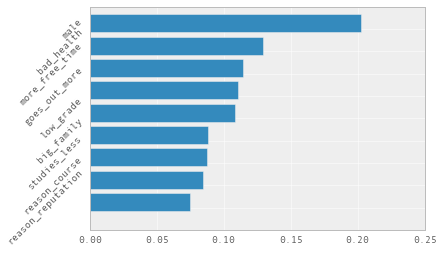

In [21]:
hist_data = []

for i, imp in enumerate(random_search.best_estimator_.feature_importances_):
   hist_data.append((selected_feature_names[0][i], imp))

hist_data.sort(key = lambda x: x[1])

imp = [x[1] for x in hist_data]
ax = plt.subplot(111)
width=0.3
names = [x[0] for x in hist_data]
bins = list(map(lambda x: x - width / 2, range(1, len(imp) + 1)))
ax.barh(bins, imp)
ax.set_yticks(list(map(lambda x: x, range(1, len(imp) + 1))))
ax.set_yticklabels(names,rotation=45)

plt.show()

# Results

In [418]:
predictions = xgb_clf.predict(x_val)


array([ 1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  3.,  1.,  2.,  2.,  1.,
        3.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,
        1.,  3.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,
        1.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,
        1.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  3.,  1.,  1.,  1.,
        1.,  1.,  1.])